In [1]:
import numpy as np
import scipy.fftpack as sfft
from ncempy import io
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.signal import convolve2d as cv2

In [2]:

loaded_data = io.dm.dmReader("EFTEM-SI_01 [0,35] eV.dm4")
data_cube = loaded_data["data"]
np.save("data/uncor_eftem_stack", data_cube)


Error reading file: "EFTEM-SI_01 [0,35] eV.dm4"


FileNotFoundError: [Errno 2] No such file or directory: 'EFTEM-SI_01 [0,35] eV.dm4'

In [2]:
eft_stack = np.load("data/uncor_eftem_stack.npy")

In [ ]:
fig = plt.figure()
fig.set_size_inches((12,6))

ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2, projection="3d")

tmp = np.arange(2)
xtmp, ytmp = np.meshgrid(tmp,tmp)
slicetmp = 0*xtmp*ytmp + 1

x = np.arange(2048)

def init():
    ax1.set_title("X-Y data per slice")
    ax1.set_xlabel("x")
    ax1.set_ylabel("y")
    ax1.pcolorfast(x, x, eft_stack[0,:,:])
    ax2.contourf(xtmp, ytmp, slicetmp, zdir="z", offset=0, cmap="gray")
    ax2.set_zlim(0,72)

def animate(i):
    ax1.pcolorfast(x, x, eft_stack[i,:,:])
    ax1.text(0,0, "Slice: "+str(i))
    ax2.clear()
    ax2.set_zlim(0,72)
    ax2.contourf(xtmp, ytmp, slicetmp, zdir="z", offset=i, cmap="gray")

anim = FuncAnimation(fig, animate, init_func=init, frames=70, interval=20)
anim.save("slices.gif");

<img src="slices.gif" />

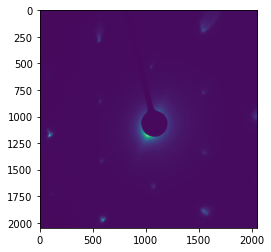

In [10]:
plt.imshow(eft_stack[25])

In [3]:
edge_x = np.array([
    [-1,0,1],
    [-1,0,1],
    [-1,0,1]
])

edge_y = np.array([
    [1,1,1],
    [0,0,0],
    [-1,-1,-1]
])

def develop(image):
    new_image = np.copy(image)[:,:]
    a = np.average(new_image)
    b = np.std(new_image)
    to_return =  np.sqrt(cv2(1/(1+np.exp(-(new_image-a)/b))*np.hamming( new_image.shape[0] ), edge_x)**2 + cv2(1/(1+np.exp(-(new_image-a)/b))*np.hamming( new_image.shape[0] ), edge_y)**2)
    return to_return

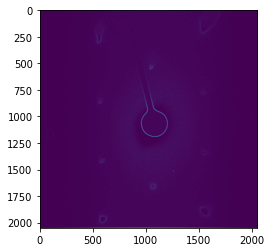

In [12]:
plt.imshow( develop(eft_stack[25] ) )

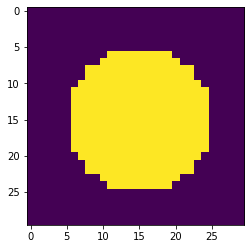

In [6]:
x = np.arange(51)-25
imgx, imgy = np.meshgrid(x, x)

dot = (np.sqrt(imgx**2 + imgy**2) < 10)[10:40,10:40]

plt.imshow(dot)

In [7]:
test_image0 = 0*imgx*imgy
test_image0[0:30,0:30] = dot
test_image1 = 0*imgx*imgy
test_image1[15:45,10:40] = dot

(27, 27)


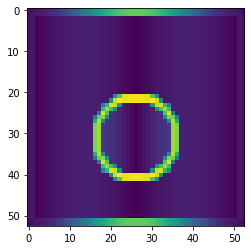

In [8]:
shift =  get_drift(develop(test_image0), develop(test_image1))
print(shift)

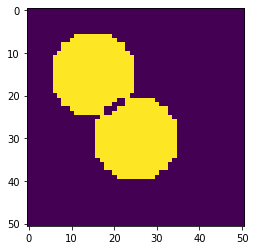

In [9]:
plt.imshow(np.abs(test_image0 - test_image1))

In [4]:
def drift(img0, img1):
    img0_win = img0*np.hanning( img0.shape[0] )
    img1_win = img1*np.hanning( img1.shape[0] )
    img0_ftm = sfft.fft2( img0_win )
    img1_ftm = sfft.fft2( img1_win )

    cross_power_spectrum = (img0_ftm * img1_ftm.conj()) / np.abs(img0_ftm * img1_ftm.conj())
    r = np.abs( sfft.ifft2( cross_power_spectrum ) )
    r = sfft.fftshift( r )

    [py,px] = np.argwhere(r==r.max())[0]
    [ydrift,xdrift] = [py-img0.shape[1]/2, px-img0.shape[0]/2]
    return [ydrift,xdrift]

In [39]:
[x,y] = drift(test_image0, test_image1)

In [6]:
test_image = np.copy(eft_stack[25])
test_image[800:1300,800:1300] = 0

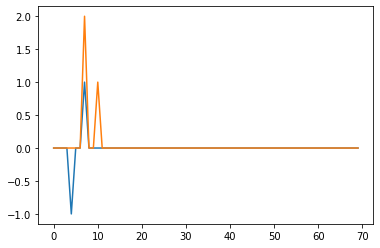

In [5]:
x_corr = np.asarray([])
y_corr = np.asarray([])

for i in range(0,eft_stack.shape[0]-1):
    [y,x] = drift(eft_stack[i],eft_stack[i+1])
    x_corr = np.append(x_corr, x)
    y_corr = np.append(y_corr, y)


plt.plot(x_corr)
plt.plot(y_corr)

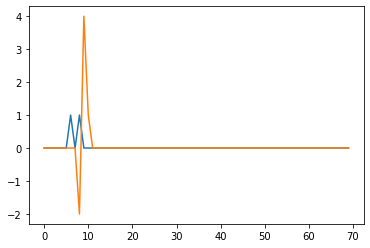

In [6]:
x_corr_dev = np.asarray([])
y_corr_dev = np.asarray([])

for i in range(0,eft_stack.shape[0]-1):
    [y,x] = drift(develop(eft_stack[i]),develop(eft_stack[i+1]))
    x_corr_dev = np.append(x_corr_dev, x)
    y_corr_dev = np.append(y_corr_dev, y)


plt.plot(x_corr_dev)
plt.plot(y_corr_dev)

In [7]:
print(x_corr)
print(y_corr)

[ 0.  0.  0.  0. -1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [8]:
def shift(image, xshift, yshift):
    new_shape = ( image.shape[0]+int(abs(yshift)) , image.shape[1]+int(abs(xshift)) )
    new_image = np.zeros( new_shape )
    new_image[0:image.shape[0], 0:image.shape[1]] = image
    y_corr = np.roll(new_image, int(yshift), axis=0)
    corrected_image = np.roll(y_corr, int(xshift), axis=1)
    return corrected_image[0:image.shape[0], 0:image.shape[1]]

In [9]:
corrected = np.zeros( eft_stack.shape )



for i in range(0,len(x_corr)):
    corrected[i,:,:] = shift( eft_stack[i], x_corr[i], y_corr[i])

np.save("data/corrected_eftem", corrected)

corrected_dev = np.zeros( eft_stack.shape )

for i in range(0,len(x_corr_dev)):
    corrected_dev[i,:,:] = shift( eft_stack[i], x_corr_dev[i], y_corr_dev[i])

np.save("data/corrected_eftem_dev", corrected_dev)

In [10]:
from matplotlib.animation import FuncAnimation, writers

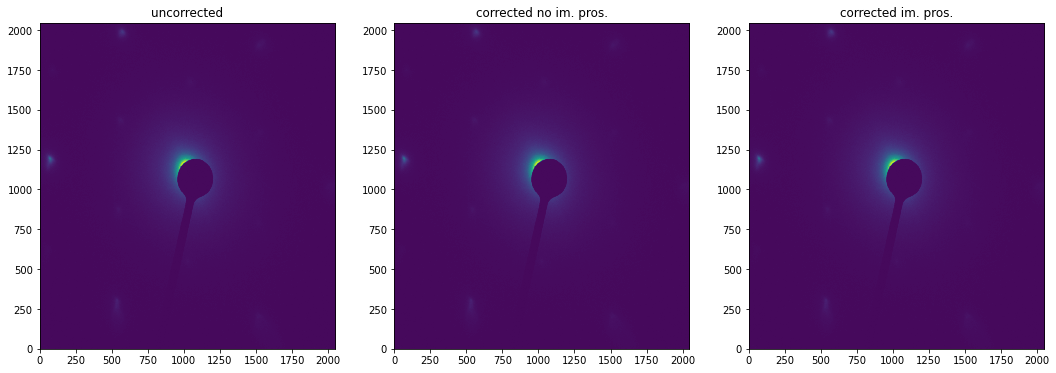

In [11]:
fig = plt.figure()
fig.set_size_inches((18,6))

ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

x = np.arange(2048)

def init():
    ax1.set_title("uncorrected")
    ax1.pcolorfast(x, x, eft_stack[0,:,:])
    ax2.set_title("corrected no im. pros.")
    ax2.pcolorfast(x, x, corrected[0,:,:])
    ax3.set_title("corrected im. pros.")
    ax3.pcolorfast(x, x, corrected_dev[0,:,:])

def animate(i):
    ax1.pcolorfast(x, x, eft_stack[i,:,:])
    ax2.pcolorfast(x, x, corrected[i,:,:])
    ax3.pcolorfast(x, x, corrected_dev[i,:,:])


anim = FuncAnimation(fig, animate, init_func=init, frames=69, interval=100)
anim.save("comparison.gif");

In [12]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [13]:
pure_data = np.load("data/data_cube.npy")
eft_stack = np.load("data/uncor_eftem_stack.npy")
corrected = np.load("data/corrected_eftem.npy")
corrected_dev = np.load("data/corrected_eftem_dev.npy")

difference_uncorr = sigmoid(eft_stack)-sigmoid(pure_data)
difference_cor_no = sigmoid(corrected)-sigmoid(pure_data)
difference_cor_pr = sigmoid(corrected_dev)-sigmoid(pure_data)

<ipython-input-12-3cbdbdecc9c7>:2: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


In [14]:
pure_data = None
eft_stack = None
corrected = None
corrected_dev = None

In [15]:
fig = plt.figure()
fig.set_size_inches((19,6))

ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

x = np.arange(2048)

def init():
    ax1.set_title("diff uncorrected")
    ax1.pcolorfast(x, x, difference_uncorr[0,:,:])
    ax2.set_title("diff corrected no im. pros.")
    ax2.pcolorfast(x, x, difference_cor_no[0,:,:])
    ax3.set_title("diff corrected im. pros.")
    ims = ax3.pcolorfast(x, x, difference_cor_pr[0,:,:])
    plt.colorbar(ims)

def animate(i):
    ax1.pcolorfast(x, x, difference_uncorr[i,:,:])
    ax2.pcolorfast(x, x, difference_cor_no[i,:,:])
    ax3.pcolorfast(x, x, difference_cor_pr[i,:,:])


anim = FuncAnimation(fig, animate, init_func=init, frames=69, interval=100)
anim.save("comparison_diff.gif");

MovieWriter stderr:
Error writing trailer of comparison_diff.gif: Invalid argument



CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '1368x432', '-pix_fmt', 'rgba', '-r', '10.0', '-loglevel', 'error', '-i', 'pipe:', '-filter_complex', 'split [a][b];[a] palettegen [p];[b][p] paletteuse', '-y', 'comparison_diff.gif']' returned non-zero exit status 255.

In [13]:
print(np.max(difference_uncorr))

0.0
